# Prepare dataset

In [8]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
import string

possible_categories = [letter.lower() for i, letter in enumerate(string.ascii_uppercase) if letter not in ['J', 'Z']]
#possible_categories.append("*") # unknown symbol
#possible_categories.extend([str(x) for x in range(0, 10)]) # digits 0-9

possible_categories.remove("r") # Remove "r" as the quality in the converted dataset wasn't sufficient

def load_dataset_from_csv(path, keep_every=1):
    df = pd.read_csv(path, dtype={63: str}, header=None)
    df = df[df[63].notna() & df[63].apply(lambda l: str(l).lower()).isin(possible_categories)]
    if keep_every > 1:
        df = df[df.index % keep_every == 0]
    df[63] = df[63].apply(lambda l: l.lower())
    return df

In [10]:
# Load own dataset
my_dataset = load_dataset_from_csv("my_dataset.csv")

# Load mnist (converted)
mnist_df = load_dataset_from_csv("mnist_dataset.csv")
mnist_df = mnist_df[mnist_df[63] != "r"] # Need to remove r as it is mainly faulty

# Load exter (converted)
exter_df = pd.DataFrame()
for p in ["A", "B", "C", "D", "E"]:
    exported_df = load_dataset_from_csv(f"exter_{p}.csv")
    exter_df = pd.concat([exter_df, exported_df])
exter_df = exter_df[exter_df[63] != "r"] # Need to remove r as it is mainly faulty

In [11]:
def category_distrib(df, title=""):
    category_counts = df[63].value_counts()
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='bar')
    plt.xlabel('Kategóriák', fontname="Calibri")
    plt.ylabel('Minták száma', fontname="Calibri")
    plt.title(title, fontname="Calibri")
    #plt.savefig('Distribution of training dataset Categories.png', dpi=300)  # High resolution
    plt.show()

def equalize_category_counts(df, category_column, max_size=None):
    # Group by category and find the maximum size
    if not max_size:
        max_size = df.groupby(category_column).size().min()

    # Resample each group
    resampled = [group.sample(max_size, replace=True) for _, group in df.groupby(category_column)]

    # Concatenate the resampled groups
    return pd.concat(resampled, ignore_index=True)

In [12]:
from sklearn.model_selection import train_test_split

# Assuming train_df contains the landmarks in order
# A better way to separate train-valid split is to take the last x% of the data. If it's done randomly with shuffling similar datapoints may appear in the validation data.

# category_distrib(train_df, "train")
train_df = pd.concat([exter_df, mnist_df])
train_df = equalize_category_counts(train_df, 63)
# category_distrib(train_df, "train equalized")
test_df = my_dataset
# category_distrib(test_df, "test")

# Find unique categories
categories = train_df[63].unique()

train_list = []
valid_list = []
for category in categories:
    category_data = train_df[train_df[63] == category]
    # 80-20% split, shuffle must be False
    train_category, val_category = train_test_split(category_data, test_size=0.2, shuffle=False)
    train_list.append(train_category)
    valid_list.append(val_category)

train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(valid_list).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [13]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.722782,0.617529,-0.000002,0.466494,0.610322,-0.139481,0.260263,0.444907,-0.183257,0.239722,...,0.893880,0.350225,-0.264919,0.859723,0.452897,-0.239904,0.832201,0.513772,-0.185454,a
1,0.568503,0.704894,-0.000002,0.376622,0.626749,-0.060602,0.242029,0.475666,-0.088952,0.179786,...,0.668897,0.289070,-0.141600,0.631848,0.393711,-0.091027,0.657887,0.430602,-0.036139,a
2,0.487123,0.518279,-0.000002,0.373471,0.550624,-0.048281,0.227151,0.448777,-0.061356,0.167707,...,0.502631,0.192942,-0.124908,0.499175,0.302702,-0.103425,0.515405,0.372475,-0.068625,a
3,0.422397,0.558416,-0.000001,0.310724,0.529793,-0.034232,0.190732,0.427884,-0.049742,0.124109,...,0.394217,0.254339,-0.117372,0.388513,0.352178,-0.096581,0.411181,0.373957,-0.069462,a
4,0.501795,0.521737,-0.000002,0.390266,0.558100,-0.038763,0.244767,0.488752,-0.056274,0.153500,...,0.392741,0.166701,-0.102737,0.418619,0.283082,-0.074529,0.448849,0.331026,-0.039363,a


In [14]:
import torch
from typing import List
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder

class GraphDataset(InMemoryDataset):
    def __init__(self, df: pd.DataFrame, transform=None, pre_transform=None):
        self.label_encoder = LabelEncoder()
        self.connections = [(0,1), (0,5), (0,17), (1,2), (2,3), (3,4), 
                            (5,6), (5,9), (6,7), (7,8), (9,10), (9,13), 
                            (10,11), (11,12), (13,14), (13,17), (14,15), 
                            (15,16), (17,18), (18,19), (19,20)]

        super().__init__(None, transform, pre_transform)
        self.data_list = self.process_data(df)

    def process_data(self, df: pd.DataFrame) -> List[Data]:
        # Encode the categorical column
        labels = self.label_encoder.fit_transform(df.iloc[:, -1])

        data_list = []
        for idx, row in df.iterrows():
            # Extract the 63 floats and reshape to (21, 3) for 3D node features
            node_features = np.array(row[:-1]).astype(np.float32).reshape(21, self.num_node_features)

            # Create the edge list and make it undirected by adding reverse connections
            edges = []
            for a, b in self.connections:
                edges.append([a, b])
                edges.append([b, a])  # Add the reverse connection
            
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

            # Create the graph data object
            x = torch.tensor(node_features, dtype=torch.float)
            y = torch.tensor(labels[idx], dtype=torch.long)
            data = Data(x=x, edge_index=edge_index, y=y)
            data_list.append(data)

        return data_list
    
    @property
    def num_classes(self):
        return len(set(self.label_encoder.classes_))

    @property
    def num_node_features(self):
        return 3

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [15]:
train_dataset = GraphDataset(train_df)
val_dataset = GraphDataset(val_df)
test_dataset = GraphDataset(test_df)

print(f'Dataset: {train_dataset}:')
print('====================')
print(f'Number of graphs: {len(train_dataset)}')
print(f'Number of features: {train_dataset.num_features}')
print(f'Number of classes: {train_dataset.num_classes}')

data = train_dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: GraphDataset(27531):
Number of graphs: 27531
Number of features: 3
Number of classes: 23

Data(x=[21, 3], edge_index=[2, 42], y=0)
Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


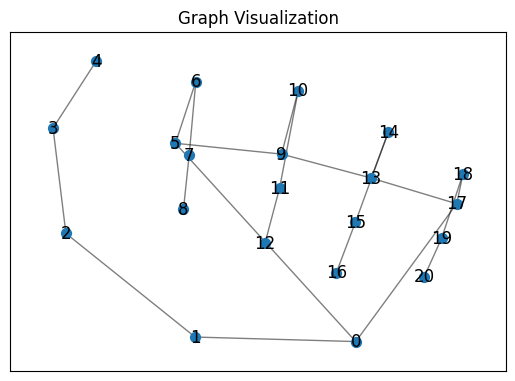

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_graph(data):
    node_features = data.x.numpy()
    edge_index = data.edge_index.numpy()
    
    x = node_features[:, 0]
    y = node_features[:, 1]

    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    pos = {i: (x[i], y[i]) for i in range(len(x))}
    
    nx.draw_networkx_nodes(G, pos, node_size=50)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Graph Visualization")
    plt.show()

graph_data = train_dataset.get(0)
visualize_graph(graph_data)

In [17]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    if step < 3:
        print(f'Step {step + 1}:')
        print('=======')
        print(f'Number of graphs in the current batch: {data.num_graphs}')
        print(data)
        print()
    else:
        break

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1344, 3], edge_index=[2, 2688], y=[64], batch=[1344], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1344, 3], edge_index=[2, 2688], y=[64], batch=[1344], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[1344, 3], edge_index=[2, 2688], y=[64], batch=[1344], ptr=[65])



In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(train_dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, train_dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=23, bias=True)
)


In [20]:
optimizer = torch.optim.Adam(model.parameters()) #, lr=0.01
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def evaluate(loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

for epoch in range(1, 100):
    train()
    val_acc = evaluate(val_loader)
    test_acc = evaluate(test_loader)
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Val Acc: 0.5036, Test Acc: 0.0653
Epoch: 002, Val Acc: 0.5003, Test Acc: 0.0658
Epoch: 003, Val Acc: 0.5103, Test Acc: 0.0667
Epoch: 004, Val Acc: 0.5128, Test Acc: 0.0699
Epoch: 005, Val Acc: 0.5196, Test Acc: 0.0664
Epoch: 006, Val Acc: 0.5209, Test Acc: 0.0697
Epoch: 007, Val Acc: 0.5161, Test Acc: 0.0722
Epoch: 008, Val Acc: 0.5194, Test Acc: 0.0682
Epoch: 009, Val Acc: 0.5207, Test Acc: 0.0645
Epoch: 010, Val Acc: 0.5317, Test Acc: 0.0694
Epoch: 011, Val Acc: 0.5277, Test Acc: 0.0688
Epoch: 012, Val Acc: 0.5220, Test Acc: 0.0667
Epoch: 013, Val Acc: 0.5361, Test Acc: 0.0701
Epoch: 014, Val Acc: 0.5359, Test Acc: 0.0703
Epoch: 015, Val Acc: 0.5365, Test Acc: 0.0683
Epoch: 016, Val Acc: 0.5370, Test Acc: 0.0719
Epoch: 017, Val Acc: 0.5387, Test Acc: 0.0670
Epoch: 018, Val Acc: 0.5393, Test Acc: 0.0677
Epoch: 019, Val Acc: 0.5439, Test Acc: 0.0706
Epoch: 020, Val Acc: 0.5441, Test Acc: 0.0681
Epoch: 021, Val Acc: 0.5432, Test Acc: 0.0672
Epoch: 022, Val Acc: 0.5475, Test 

KeyboardInterrupt: 

In [51]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        torch.manual_seed(42)
        self.fc1 = Linear(input_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, hidden_dim)
        self.out = Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.reshape(-1)
        
        # 1. Hidden layer with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # 2. Output layer
        x = F.softmax(self.out(x), dim=0)
        
        return x

model = MLP(input_dim=63, hidden_dim=16, output_dim=train_dataset.num_classes)
print(model)

MLP(
  (fc1): Linear(in_features=63, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=23, bias=True)
)


In [1]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    for data in train_dataset:
        out = model(data.x)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def evaluate(dataset):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in dataset:
            out = model(data.x)
            pred = out.argmax(dim=0)
            correct += int((pred == data.y).sum())
    return correct / len(dataset)

for epoch in range(1, 100):
    train()
    val_acc = evaluate(val_dataset)
    test_acc = evaluate(test_dataset)
    print(f'Epoch: {epoch:03d}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')